## Import required packages

In [1]:
%matplotlib notebook
import geopandas as gpd
import pandas as pd
import os
import matplotlib.pyplot as plt
import shapely
import time
import pickle
import networkx as nx
from tqdm import tqdm

# Load in the required dataframe in shapefile format

In [2]:
ocean_df = gpd.read_file("./databases/groads-v1-oceania-east-shp/")

In [10]:
europe_df = gpd.read_file("./databases/groads-v1-europe-shp/")

In [28]:
AM_df = gpd.read_file("./databases/groads-v1-americas-shp/")

In [33]:
africa_df = gpd.read_file("./databases/groads-v1-africa-shp/")

# Cut out the required continent and visualize (shapefile format)

<IPython.core.display.Javascript object>


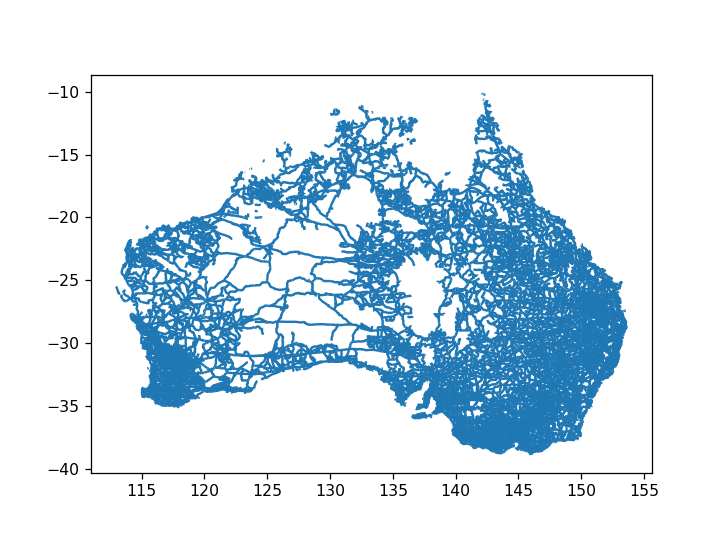

In [3]:
# Australia
AU_shape = shapely.geometry.Polygon([(100, -20), (130, -9.5), (145, -9.5),
                                            (155, -25), (153, -39),(116, -39)])
AU_df = ocean_df.loc[ocean_df['geometry'].apply(AU_shape.contains)]

AU_df.plot()
plt.show()

<IPython.core.display.Javascript object>


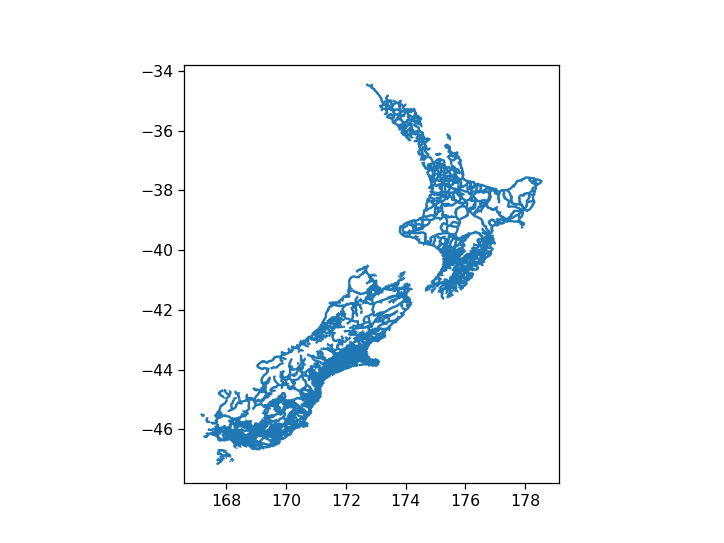

In [6]:
# New Zealand
NZ_shape = shapely.geometry.Polygon([(170, -32), (180, -38),(170,-49), (163.5, -49.5)])
NZ_df = ocean_df.loc[ocean_df['geometry'].apply(NZ_shape.contains)]

NZ_df.plot()
plt.show()

<IPython.core.display.Javascript object>


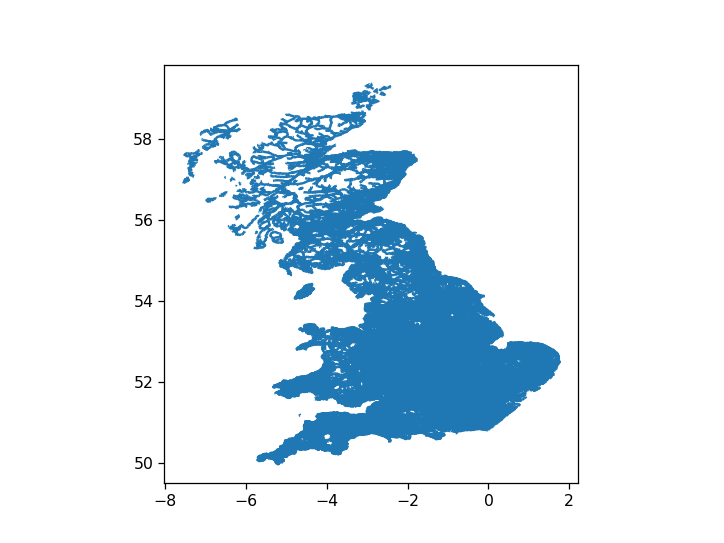

In [11]:
# United Kingdom without North Ireland
UK_shape = shapely.geometry.Polygon([(-5, 54.5), (-11, 60), (-3, 60),
                                            (2.75, 53), (-1, 50),(-6, 49)])
UK_df = europe_df.loc[europe_df['geometry'].apply(UK_shape.contains)]

UK_df.plot()
plt.show()

<IPython.core.display.Javascript object>


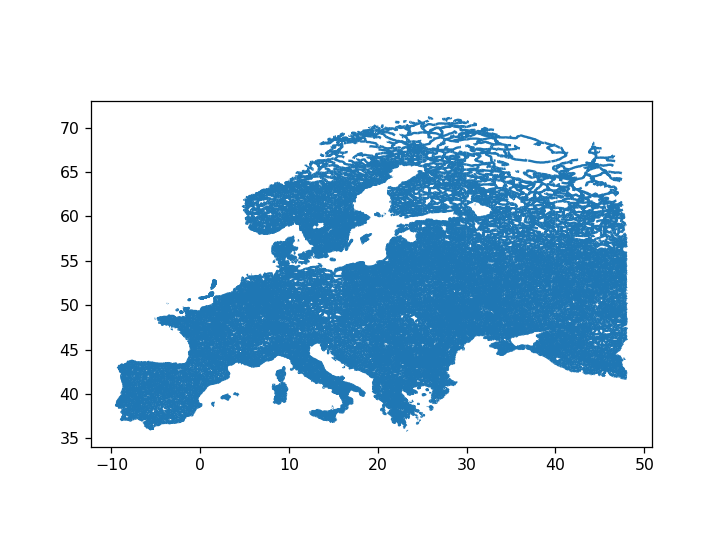

In [25]:
#Europe
EU_shape = shapely.geometry.Polygon([(20, 72), (47, 73), (49, 41.5),
                                            (31.5, 44), (23, 35),(5, 39),(-5, 36),(-10.5, 36),
                                            (-11, 49),(1, 51),(4.5, 63)])
EU_df = europe_df.loc[europe_df['geometry'].apply(EU_shape.contains)]

EU_df.plot()
plt.show()

<IPython.core.display.Javascript object>


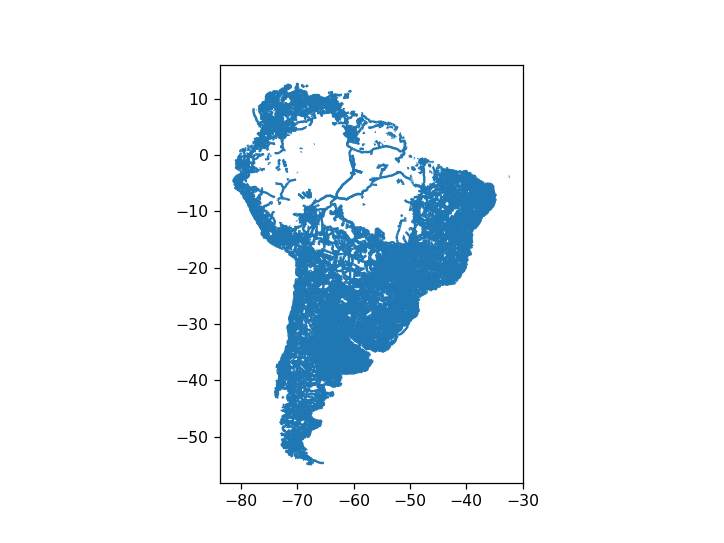

In [29]:
# South America
S_AM_shape = shapely.geometry.Polygon([(-86.5, -2), (-71, 16.5), (-27.5, -5),
                                            (-63, -52), (-64, -58),(-81, -55)])

S_AM_df = AM_df.loc[AM_df['geometry'].apply(S_AM_shape.contains)]

S_AM_df.plot()
plt.show()

<IPython.core.display.Javascript object>


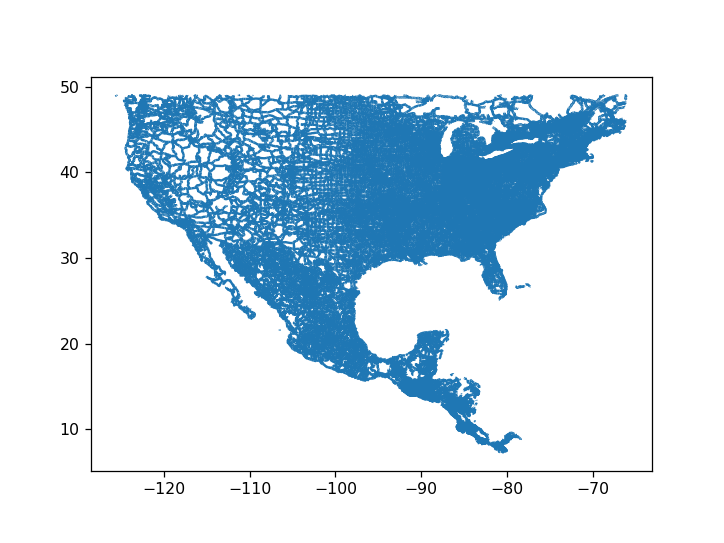

In [31]:
# North America
N_AM_shape = shapely.geometry.Polygon([(-128.5, 49), (-66, 49), (-67, 31),
                                            (-86, 23), (-78, 11),(-79, 5),(-122.5, 14.5)])

N_AM_df = AM_df.loc[AM_df['geometry'].apply(N_AM_shape.contains)]

N_AM_df.plot()
plt.show()

<IPython.core.display.Javascript object>


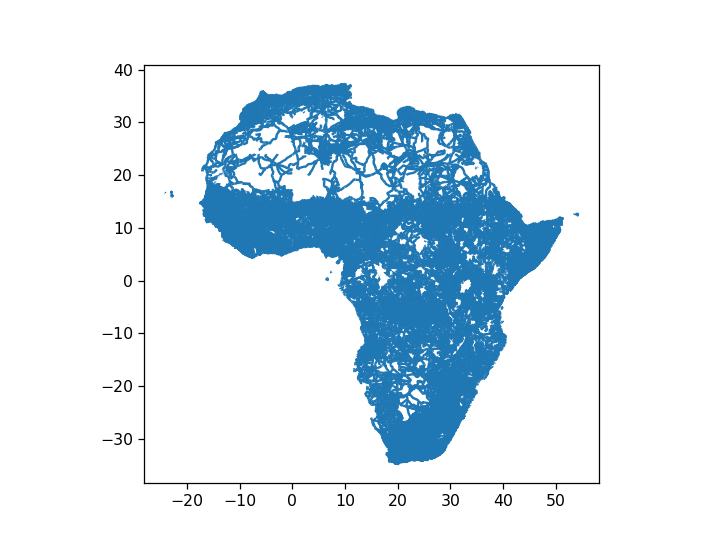

In [34]:
# Africa
AF_shape = shapely.geometry.Polygon([(-1.5, 36), (-6.5, 36), (-24.5, 17),
                                            (23.5, -41.5), (56.5, 16),(44.5, 11),(30.5, 33.5),(12.5,34.5),(11,39)])

AF_df = africa_df.loc[africa_df['geometry'].apply(AF_shape.contains)]

AF_df.plot()
plt.show()

# Create a networkx Graph

In [96]:

def crossing_index(crossing, candidate):
    """Check whether node allready exists on this place or generate new node name."""
    if candidate in crossing:
        return crossing[candidate]
    else:
        crossing[candidate] = len(crossing)
        return crossing[candidate]
        
def make_graph(dataframe):
    """make a networkx graph given a GeoPandas dataframe."""
    G=nx.Graph()

    MAX_ROAD_LEN = 50
    MIN_COLOR = 0.3
    # Save (x,y) = nodenumber in a dictionairy.
    crossings = {}
    # contains [crossing_index1, crossing_index2, length] as values
    # completely built on the idea that there is no crossing within a road
    # crossings only occur at the ends of the road (a new road starts after the crossing)
    for global_index, road_attrs in tqdm(dataframe.iterrows()):
        line = road_attrs['geometry']
        length = road_attrs['LENGTH_KM']
        # Skip multilinestring roads. Use remove_multistring to unpack them.
        try:
            road_points = list(line.coords)
        except NotImplementedError:
            print ("skipping multilinestring")
        # the roads begin and end coordinateIDs
        beginID = crossing_index(crossings, road_points[0])
        endID = crossing_index(crossings, road_points[-1])
        
        # add the roads as edges to the network
        G.add_edge(beginID, endID, ROADID = road_attrs["ROADID"], FCLASS = road_attrs["FCLASS"],
                    CRGWAY = road_attrs["CRGWAY"], NUMLANES = road_attrs["NUMLANES"], SPEEDLIMIT = road_attrs["SPEEDLIMIT"],
                  GNRALSPEED = road_attrs["GNRALSPEED"], LENGTH_KM = length)
        
    pos = {v:k for k,v in crossings.items()}
    nx.set_node_attributes(G, pos, "coords")
    
    return G
           
def plot_graph(G):
    """Plot networkx graph. Whereby position is given by coords attribute"""
    plt.figure()
    # list of all edges
    edges = [(u,v) for (u,v,d) in G.edges(data=True)]
    # positions for all nodes
    pos = nx.get_node_attributes(G, "coords")

    # nodes
    nx.draw_networkx_nodes(G,pos = pos, node_size=1, node_color='r', node_shape='v')

    # colour edges based on their weights
    edges, weights = zip(*nx.get_edge_attributes(G,'LENGTH_KM').items())
    nx.draw_networkx_edges(G, pos = pos, edgelist=edges, edge_color=weights, width=1, edge_cmap=plt.cm.Blues)
    #nx.draw(G, pos = pos)

    #small_df.plot()
    plt.show()
    
def save_graph(G, path):
    """Save the graph at the given path in pickle format"""
    nx.write_gpickle(G, path)


29942it [00:03, 8998.77it/s]


<IPython.core.display.Javascript object>


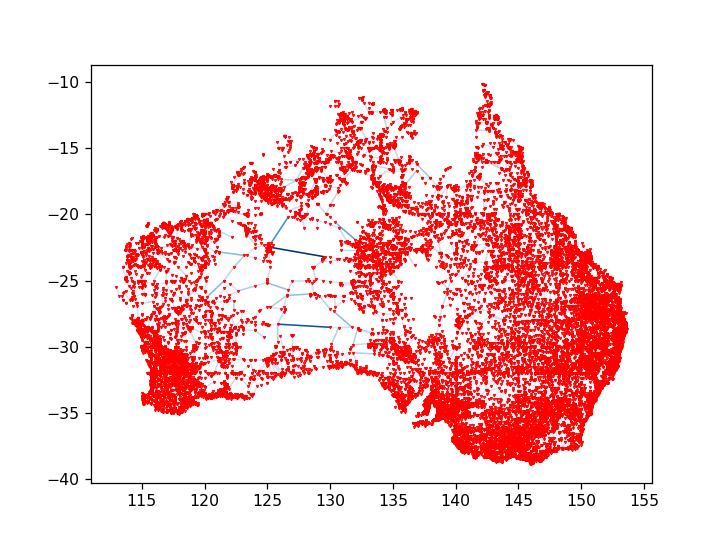

In [97]:
Graph = make_graph(AU_df)
plot_graph(Graph, )
save_graph(Graph, "databases/australia")

13510it [00:01, 8082.63it/s]


<IPython.core.display.Javascript object>


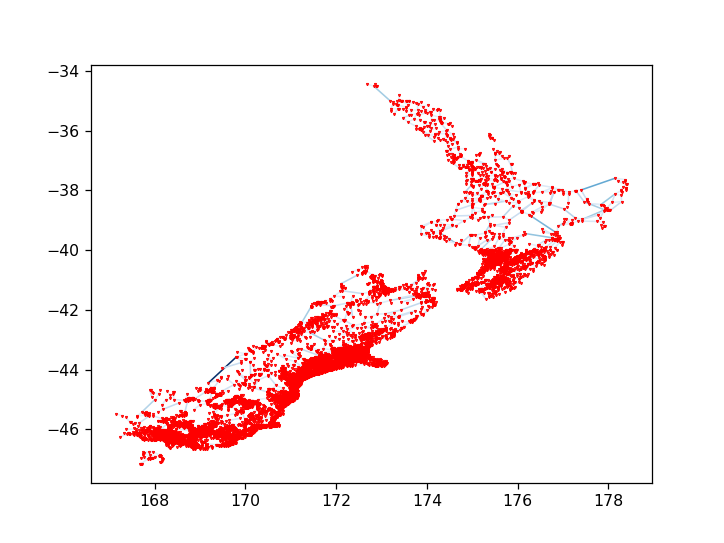

In [98]:
Graph = make_graph(NZ_df)
plot_graph(Graph)
save_graph(Graph, "databases/newzealand")

29375it [00:03, 7552.03it/s]

skipping multilinestring


217442it [00:24, 8854.67it/s]

skipping multilinestring


238441it [00:26, 8843.45it/s]


<IPython.core.display.Javascript object>


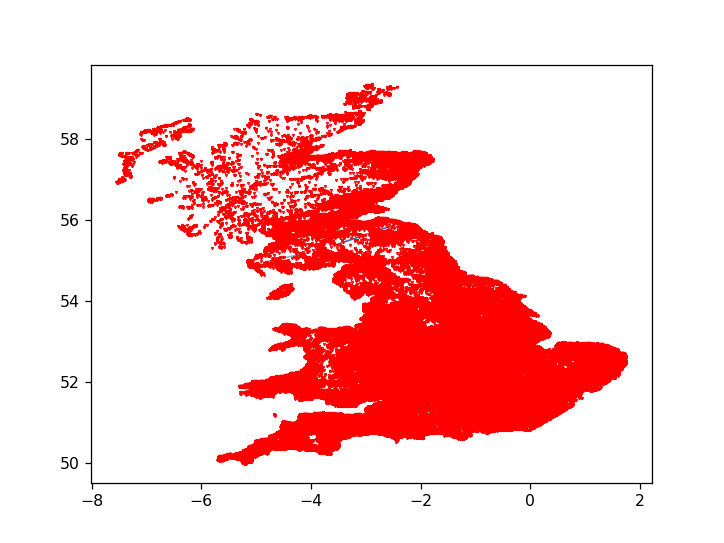

In [99]:
Graph = make_graph(UK_df)
plot_graph(Graph)
save_graph(Graph, "databases/UK")

14136it [00:01, 7604.21it/s]

skipping multilinestring


48696it [00:06, 7659.15it/s]

skipping multilinestring


95885it [00:12, 7899.71it/s]


<IPython.core.display.Javascript object>


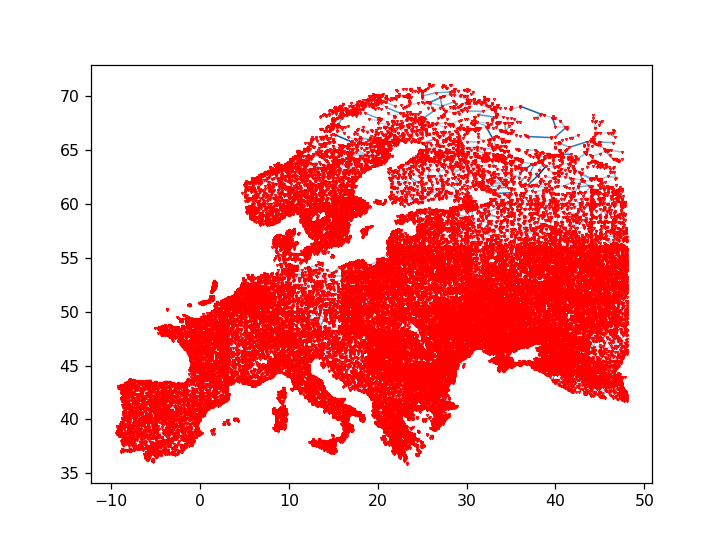

In [100]:
Graph = make_graph(EU_df)
plot_graph(Graph)
save_graph(Graph, "databases/europa")

45977it [00:05, 8152.90it/s]


<IPython.core.display.Javascript object>


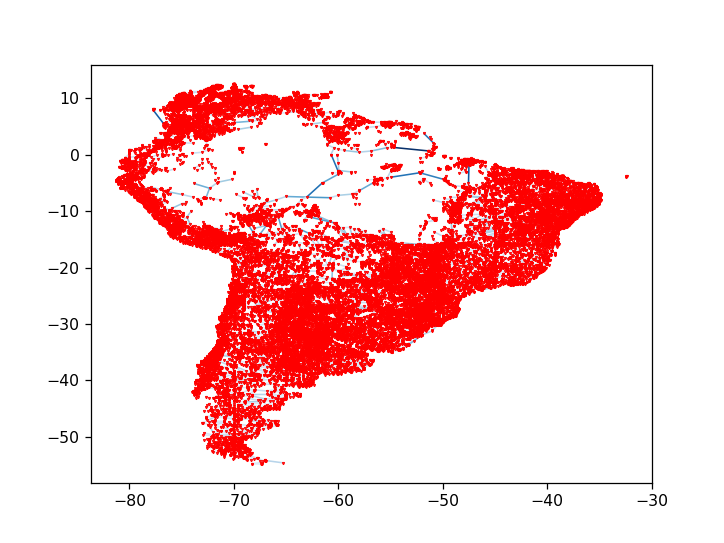

In [101]:
Graph = make_graph(S_AM_df)
plot_graph(Graph)
save_graph(Graph, "databases/southamerica")


366655it [00:43, 8391.63it/s]


<IPython.core.display.Javascript object>


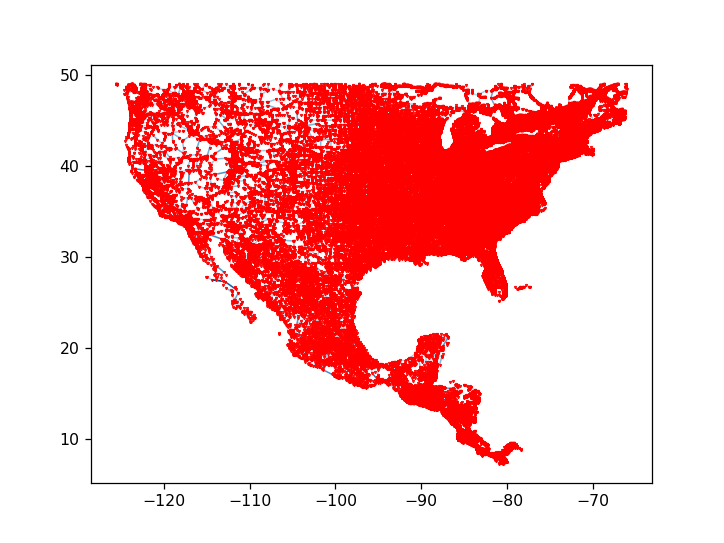

In [102]:
Graph = make_graph(N_AM_df)
plot_graph(Graph)
save_graph(Graph, "databases/northamerica")


1it [00:00,  2.91it/s]

skipping multilinestring
skipping multilinestring
skipping multilinestring
skipping multilinestring
skipping multilinestring
skipping multilinestring
skipping multilinestring
skipping multilinestring
skipping multilinestring
skipping multilinestring
skipping multilinestring
skipping multilinestring
skipping multilinestring
skipping multilinestring
skipping multilinestring
skipping multilinestring
skipping multilinestring
skipping multilinestring


250it [00:00, 551.86it/s]

skipping multilinestring
skipping multilinestring


1929it [00:00, 2871.64it/s]

skipping multilinestring


3726it [00:00, 4184.38it/s]

skipping multilinestring


4481it [00:00, 4482.11it/s]

skipping multilinestring


6171it [00:01, 5064.49it/s]

skipping multilinestring
skipping multilinestring


6988it [00:01, 5262.54it/s]

skipping multilinestring


7838it [00:01, 5453.68it/s]

skipping multilinestring
skipping multilinestring


11559it [00:01, 6166.15it/s]

skipping multilinestring


13496it [00:02, 6447.23it/s]

skipping multilinestring


14411it [00:02, 6542.57it/s]

skipping multilinestring


15351it [00:02, 6639.68it/s]

skipping multilinestring
skipping multilinestring
skipping multilinestring


16209it [00:02, 6694.19it/s]

skipping multilinestring


17045it [00:02, 6735.27it/s]

skipping multilinestring


24716it [00:03, 7257.72it/s]

skipping multilinestring
skipping multilinestring
skipping multilinestring


26572it [00:03, 7331.90it/s]

skipping multilinestring


27442it [00:03, 7350.12it/s]

skipping multilinestring
skipping multilinestring


30199it [00:04, 7435.26it/s]

skipping multilinestring
skipping multilinestring


31087it [00:04, 7453.23it/s]

skipping multilinestring


33909it [00:04, 7537.08it/s]

skipping multilinestring
skipping multilinestring
skipping multilinestring


37645it [00:04, 7626.02it/s]

skipping multilinestring


40549it [00:05, 7702.49it/s]

skipping multilinestring
skipping multilinestring


41516it [00:05, 7725.73it/s]

skipping multilinestring


44371it [00:05, 7781.91it/s]

skipping multilinestring
skipping multilinestring
skipping multilinestring


46234it [00:05, 7809.11it/s]

skipping multilinestring
skipping multilinestring


47103it [00:06, 7811.59it/s]

skipping multilinestring
skipping multilinestring


48011it [00:06, 7820.33it/s]

skipping multilinestring


50950it [00:06, 7878.11it/s]

skipping multilinestring
skipping multilinestring


55839it [00:07, 7961.05it/s]

skipping multilinestring


58725it [00:07, 7998.44it/s]

skipping multilinestring
skipping multilinestring


66456it [00:09, 6951.25it/s]

skipping multilinestring
skipping multilinestring


71182it [00:10, 7042.82it/s]

skipping multilinestring


72161it [00:10, 7063.26it/s]

skipping multilinestring


73102it [00:10, 7079.57it/s]

skipping multilinestring


78053it [00:10, 7178.94it/s]

skipping multilinestring
skipping multilinestring


78973it [00:10, 7191.27it/s]

skipping multilinestring


79898it [00:11, 7203.73it/s]

skipping multilinestring


80843it [00:11, 7217.77it/s]

skipping multilinestring


83751it [00:11, 7264.67it/s]

skipping multilinestring
skipping multilinestring


87658it [00:11, 7325.58it/s]

skipping multilinestring
skipping multilinestring
skipping multilinestring


88556it [00:12, 7333.63it/s]

skipping multilinestring
skipping multilinestring


90372it [00:12, 7350.88it/s]

skipping multilinestring
skipping multilinestring


93227it [00:12, 7386.02it/s]

skipping multilinestring


97162it [00:13, 7439.95it/s]

skipping multilinestring
skipping multilinestring


98101it [00:13, 7449.51it/s]

skipping multilinestring
skipping multilinestring


100008it [00:13, 7470.24it/s]

skipping multilinestring


103956it [00:13, 7519.47it/s]

skipping multilinestring


104909it [00:13, 7528.84it/s]

skipping multilinestring


109787it [00:14, 7581.45it/s]

skipping multilinestring


110741it [00:14, 7590.01it/s]

skipping multilinestring


111675it [00:14, 7597.08it/s]

skipping multilinestring


114610it [00:15, 7626.56it/s]

skipping multilinestring
skipping multilinestring


117482it [00:15, 7650.66it/s]

skipping multilinestring


118473it [00:15, 7660.66it/s]

skipping multilinestring


120427it [00:15, 7678.39it/s]

skipping multilinestring


121353it [00:15, 7683.88it/s]

skipping multilinestring
skipping multilinestring


122261it [00:15, 7688.15it/s]

skipping multilinestring


123186it [00:16, 7693.40it/s]

skipping multilinestring


124154it [00:16, 7701.26it/s]

skipping multilinestring
skipping multilinestring


127041it [00:16, 7723.19it/s]

skipping multilinestring


128994it [00:16, 7739.03it/s]

skipping multilinestring
skipping multilinestring
skipping multilinestring


129883it [00:16, 7741.59it/s]

skipping multilinestring


130818it [00:16, 7746.79it/s]

skipping multilinestring


135746it [00:17, 7786.53it/s]

skipping multilinestring


139668it [00:17, 7815.39it/s]

skipping multilinestring


141592it [00:18, 7827.29it/s]

skipping multilinestring
skipping multilinestring


144411it [00:18, 7840.91it/s]

skipping multilinestring


145337it [00:18, 7844.64it/s]

skipping multilinestring


146302it [00:18, 7850.37it/s]

skipping multilinestring


147232it [00:18, 7854.19it/s]

skipping multilinestring


148158it [00:18, 7857.76it/s]

skipping multilinestring
skipping multilinestring


149049it [00:18, 7859.43it/s]

skipping multilinestring
skipping multilinestring
skipping multilinestring


151877it [00:19, 7872.39it/s]

skipping multilinestring


157751it [00:19, 7907.91it/s]

skipping multilinestring


158680it [00:20, 7911.12it/s]

skipping multilinestring


160617it [00:20, 7921.32it/s]

skipping multilinestring
skipping multilinestring


164506it [00:20, 7941.81it/s]

skipping multilinestring


165500it [00:20, 7947.83it/s]

skipping multilinestring
skipping multilinestring
skipping multilinestring


168318it [00:21, 7957.79it/s]

skipping multilinestring


169275it [00:21, 7961.88it/s]

skipping multilinestring


173237it [00:21, 7983.98it/s]

skipping multilinestring


174177it [00:21, 7987.06it/s]

skipping multilinestring
skipping multilinestring


175068it [00:21, 7987.85it/s]

skipping multilinestring
skipping multilinestring


178947it [00:22, 8005.08it/s]

skipping multilinestring


179912it [00:22, 8009.09it/s]

skipping multilinestring


182818it [00:22, 8021.31it/s]

skipping multilinestring


183765it [00:22, 8024.35it/s]

skipping multilinestring


184686it [00:23, 8026.26it/s]

skipping multilinestring


187427it [00:23, 8030.86it/s]

skipping multilinestring


188329it [00:23, 8031.89it/s]

skipping multilinestring
skipping multilinestring


191866it [00:23, 8032.89it/s]

skipping multilinestring


199987it [00:24, 8041.56it/s]

skipping multilinestring


204566it [00:25, 8048.74it/s]

skipping multilinestring
skipping multilinestring


206317it [00:25, 8048.36it/s]

skipping multilinestring


208104it [00:25, 8049.40it/s]

skipping multilinestring


208981it [00:25, 8049.28it/s]

skipping multilinestring
skipping multilinestring
skipping multilinestring
skipping multilinestring


211282it [00:26, 8026.83it/s]

skipping multilinestring
skipping multilinestring
skipping multilinestring


214548it [00:26, 7980.40it/s]

skipping multilinestring


215150it [00:26, 7970.38it/s]

skipping multilinestring


215757it [00:27, 7960.61it/s]

skipping multilinestring
skipping multilinestring


217650it [00:27, 7934.42it/s]

skipping multilinestring


218894it [00:27, 7916.65it/s]

skipping multilinestring
skipping multilinestring


219510it [00:27, 7907.67it/s]

skipping multilinestring
skipping multilinestring


220112it [00:27, 7898.23it/s]

skipping multilinestring
skipping multilinestring
skipping multilinestring


225306it [00:28, 7868.49it/s]

skipping multilinestring


276912it [00:34, 7966.98it/s]

skipping multilinestring


279680it [00:35, 7971.37it/s]

skipping multilinestring


282439it [00:35, 7975.44it/s]

skipping multilinestring
skipping multilinestring


283292it [00:35, 7974.90it/s]

skipping multilinestring
skipping multilinestring


284163it [00:35, 7974.88it/s]

skipping multilinestring


285013it [00:35, 7974.25it/s]

skipping multilinestring
skipping multilinestring
skipping multilinestring


285863it [00:35, 7973.64it/s]

skipping multilinestring
skipping multilinestring
skipping multilinestring
skipping multilinestring


286667it [00:35, 7971.75it/s]

skipping multilinestring
skipping multilinestring
skipping multilinestring


287446it [00:36, 7969.18it/s]

skipping multilinestring
skipping multilinestring


288205it [00:36, 7966.07it/s]

skipping multilinestring
skipping multilinestring


288964it [00:36, 7962.99it/s]

skipping multilinestring
skipping multilinestring


289698it [00:36, 7959.23it/s]

skipping multilinestring
skipping multilinestring
skipping multilinestring
skipping multilinestring


290408it [00:36, 7954.84it/s]

skipping multilinestring
skipping multilinestring
skipping multilinestring


291100it [00:36, 7949.99it/s]

skipping multilinestring
skipping multilinestring
skipping multilinestring
skipping multilinestring
skipping multilinestring


291860it [00:36, 7947.00it/s]

skipping multilinestring
skipping multilinestring
skipping multilinestring


292646it [00:36, 7944.76it/s]

skipping multilinestring
skipping multilinestring
skipping multilinestring


293415it [00:36, 7942.04it/s]

skipping multilinestring
skipping multilinestring


294209it [00:37, 7940.04it/s]

skipping multilinestring
skipping multilinestring
skipping multilinestring


294973it [00:37, 7937.23it/s]

skipping multilinestring
skipping multilinestring
skipping multilinestring
skipping multilinestring


304690it [00:38, 7919.09it/s]

skipping multilinestring


308210it [00:38, 7920.53it/s]

skipping multilinestring


309089it [00:39, 7920.87it/s]

skipping multilinestring


310789it [00:39, 7920.05it/s]

skipping multilinestring


312511it [00:39, 7919.78it/s]

skipping multilinestring


314236it [00:39, 7919.61it/s]

skipping multilinestring
skipping multilinestring


315038it [00:39, 7918.00it/s]

skipping multilinestring
skipping multilinestring


317492it [00:40, 7914.43it/s]

skipping multilinestring


319199it [00:40, 7913.83it/s]

skipping multilinestring
skipping multilinestring


321459it [00:40, 7902.52it/s]

skipping multilinestring


323127it [00:40, 7901.05it/s]

skipping multilinestring


323940it [00:41, 7899.82it/s]

skipping multilinestring
skipping multilinestring
skipping multilinestring


324698it [00:41, 7897.24it/s]

skipping multilinestring
skipping multilinestring


325481it [00:41, 7895.29it/s]

skipping multilinestring


327136it [00:41, 7893.56it/s]

skipping multilinestring
skipping multilinestring


328763it [00:41, 7891.17it/s]

skipping multilinestring


329572it [00:41, 7889.87it/s]

skipping multilinestring
skipping multilinestring
skipping multilinestring


331213it [00:41, 7887.87it/s]

skipping multilinestring


332913it [00:42, 7887.28it/s]

skipping multilinestring
skipping multilinestring


333779it [00:42, 7887.36it/s]

skipping multilinestring


334638it [00:42, 7887.28it/s]

skipping multilinestring


335477it [00:42, 7886.73it/s]

skipping multilinestring


336297it [00:42, 7885.73it/s]

skipping multilinestring
skipping multilinestring
skipping multilinestring
skipping multilinestring
skipping multilinestring


337066it [00:42, 7883.54it/s]

skipping multilinestring


337857it [00:42, 7881.88it/s]

skipping multilinestring
skipping multilinestring


338652it [00:42, 7880.33it/s]

skipping multilinestring


340224it [00:43, 7876.82it/s]

skipping multilinestring
skipping multilinestring


340952it [00:43, 7870.91it/s]

skipping multilinestring


342942it [00:43, 7851.72it/s]

skipping multilinestring


343680it [00:43, 7848.97it/s]

skipping multilinestring
skipping multilinestring


345294it [00:44, 7846.64it/s]

skipping multilinestring


347774it [00:44, 7844.52it/s]

skipping multilinestring


348619it [00:44, 7844.23it/s]

skipping multilinestring
skipping multilinestring
skipping multilinestring
skipping multilinestring


350260it [00:44, 7842.56it/s]

skipping multilinestring
skipping multilinestring
skipping multilinestring


351075it [00:44, 7841.61it/s]

skipping multilinestring


351932it [00:44, 7841.60it/s]

skipping multilinestring


352757it [00:44, 7840.87it/s]

skipping multilinestring


353583it [00:45, 7840.18it/s]

skipping multilinestring
skipping multilinestring


354340it [00:45, 7835.26it/s]

skipping multilinestring
skipping multilinestring
skipping multilinestring
skipping multilinestring
skipping multilinestring


355052it [00:45, 7829.37it/s]

skipping multilinestring
skipping multilinestring


355744it [00:45, 7825.75it/s]

skipping multilinestring
skipping multilinestring
skipping multilinestring


356405it [00:45, 7821.48it/s]

skipping multilinestring
skipping multilinestring
skipping multilinestring


357103it [00:45, 7818.03it/s]

skipping multilinestring


358773it [00:45, 7817.17it/s]

skipping multilinestring


359625it [00:46, 7817.10it/s]

skipping multilinestring


362279it [00:46, 7819.04it/s]

skipping multilinestring


363195it [00:46, 7820.35it/s]

skipping multilinestring


364036it [00:46, 7820.05it/s]

skipping multilinestring


367421it [00:46, 7821.89it/s]


<IPython.core.display.Javascript object>


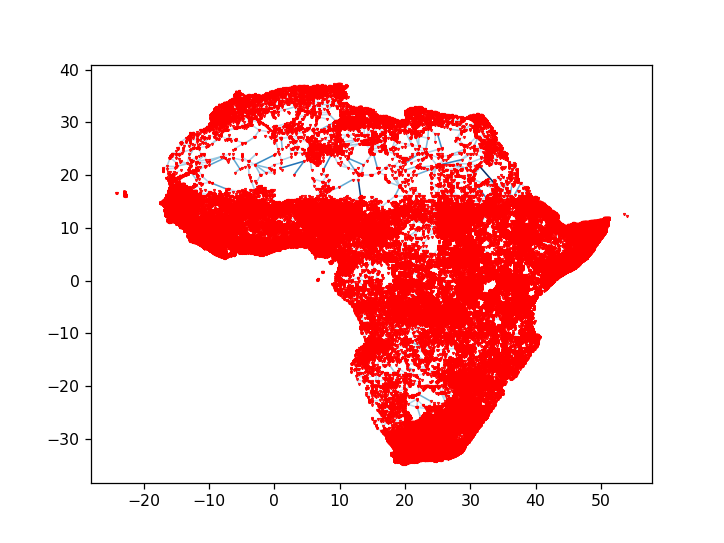

In [105]:
Graph = make_graph(AF_df)
plot_graph(Graph)
save_graph(Graph, "databases/africa")

In [104]:

def remove_multistring(dataframe):
    """ Unpack the multi linestring into single row Linestring (Does keep the linestrings, they just get skipped)."""
    listy = []

    # Loop over every entry in the dataframe and check for multilinestrings
    for _ , road_attrs in tqdm(dataframe.iterrows(), desc = "iterating objects", position = 0, total = 367421):
        if isinstance(road_attrs['geometry'],  shapely.geometry.multilinestring.MultiLineString):
            for element in road_attrs['geometry']:
                entrygood = road_attrs
                entrygood['geometry'] = element
                listy.append(entrygood)
                
    dataframe.append(listy)   
    
    return dataframe

AF_df = remove_multistring(AF_df)

iterating objects: 100%|████████████████████████████████████████████████████| 367421/367421 [00:17<00:00, 21019.14it/s]
